<a href="https://colab.research.google.com/github/fadymaher24/Ventilator-Pressure-Prediction/blob/main/Ventilator%20Pressure%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ventilator Pressure Prediction**


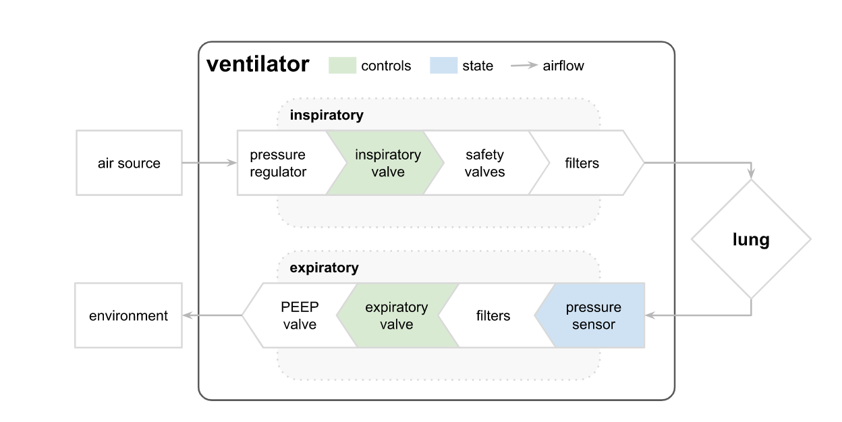

#Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
from tensorflow import keras

# Reading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip  "/content/drive/MyDrive/ventilator-pressure-prediction.zip"

Archive:  /content/drive/MyDrive/ventilator-pressure-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# data_samples=pd.read_csv('sample_submission.csv')
# data_samples

,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
4023995,4023996,0
4023996,4023997,0
4023997,4023998,0
4023998,4023999,0


In [ ]:
data_train=pd.read_csv('train.csv')
data_train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [ ]:
data_test=pd.read_csv('test.csv')
data_test.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


#Visualizations of Data

In [ ]:
DF_train = data_train.copy()
DF_train=DF_train.drop(['id','breath_id'],axis=1)

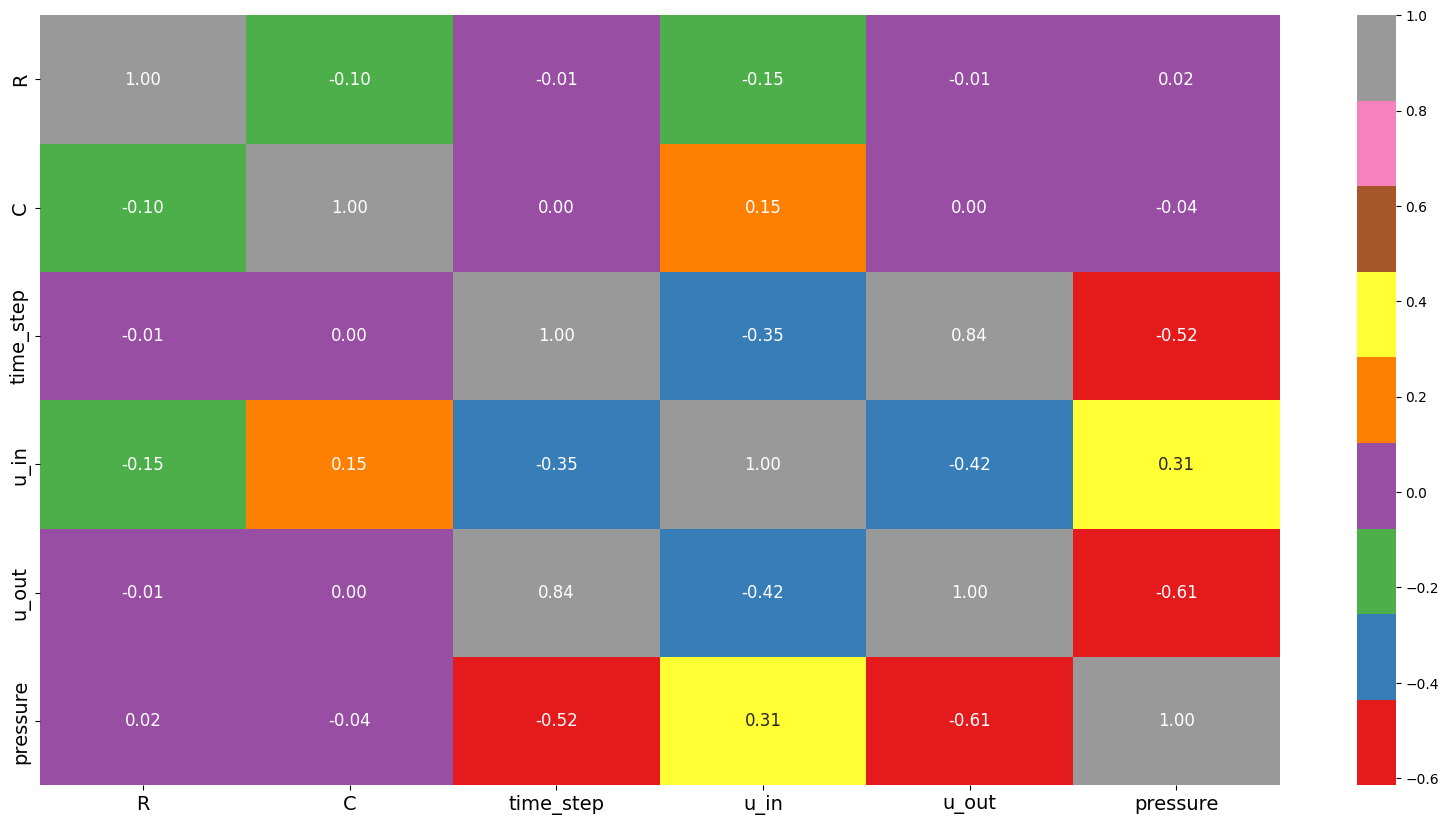

In [ ]:
import seaborn as sns
plt.figure(figsize = (20,10))
sns.heatmap(DF_train.corr(), annot = True, fmt = '3.2f' , annot_kws={'size' : 12}, cmap="Set1")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

- Only the control input for the exploratory solenoid valve i.e. u_out, showing high positive correlation with time and moderately negative correlation to Pressure.
- u_in has good positive correlation with pressure.

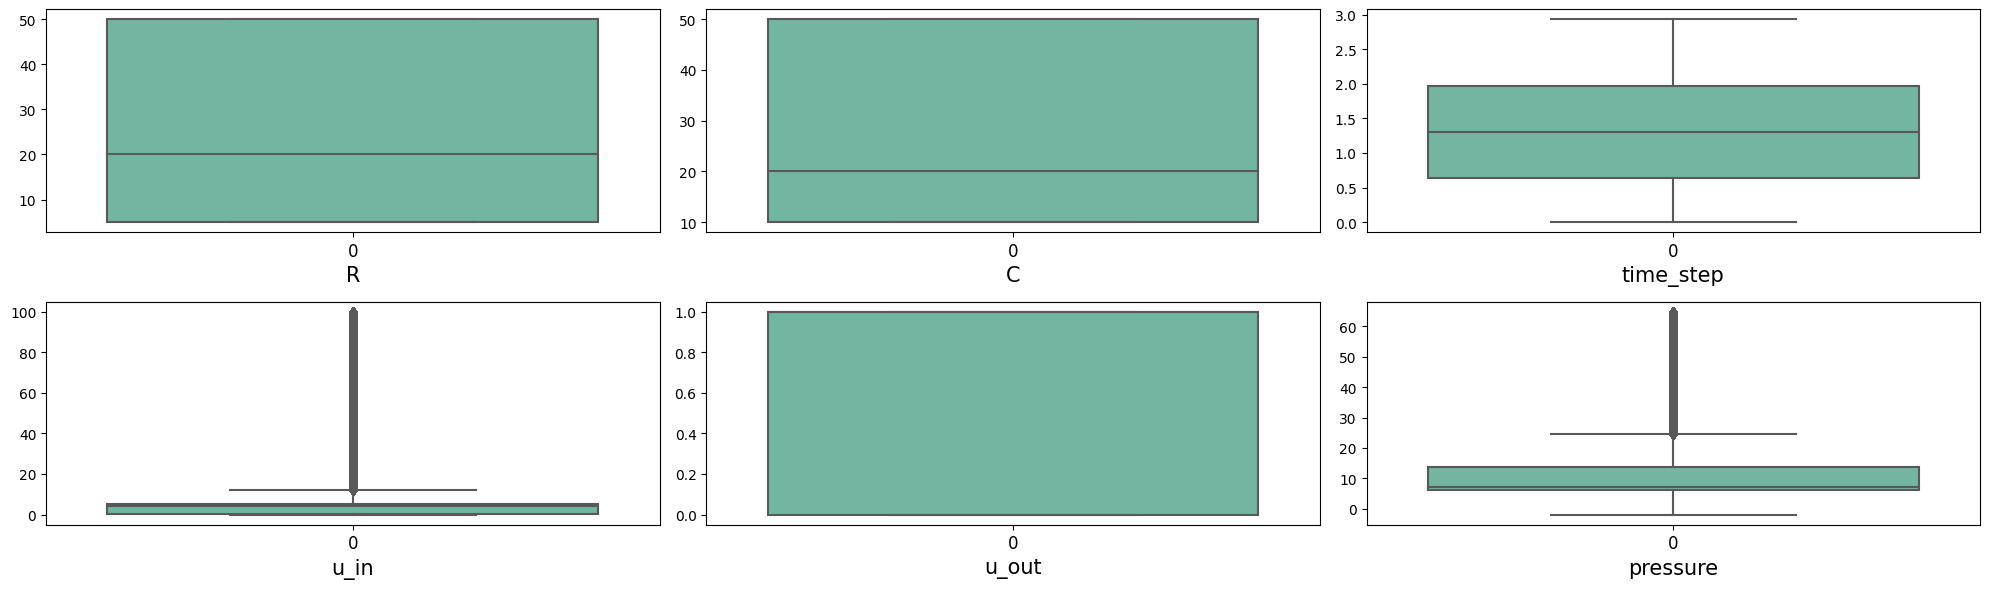

In [ ]:
a = 2
b = 3
c = 1

plt.figure(figsize = (20,6))
for col in DF_train.columns:
    plt.subplot(a,b,c)
    sns.boxplot(DF_train[col], palette='Set2')
    plt.xlabel('{}'.format(col), fontsize = 15)
    plt.xticks(fontsize = 12)

    c = c+1

plt.tight_layout()

In [ ]:
DF_train

,R,C,time_step,u_in,u_out,pressure
0,20,50,0.000000,0.083334,0,5.837492
1,20,50,0.033652,18.383041,0,5.907794
2,20,50,0.067514,22.509278,0,7.876254
3,20,50,0.101542,22.808822,0,11.742872
4,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...
6035995,50,10,2.504603,1.489714,1,3.869032
6035996,50,10,2.537961,1.488497,1,3.869032
6035997,50,10,2.571408,1.558978,1,3.798729
6035998,50,10,2.604744,1.272663,1,4.079938


In [ ]:
DF_train.isnull().any()

R            False
C            False
time_step    False
u_in         False
u_out        False
pressure     False
dtype: bool

In [ ]:
DF_train.describe()

,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [ ]:
# DF_train['id'].duplicated().any()

#Features Engineering

To enhance the code we make feature engineering, we can incorporate the following steps:

- Compute the Standard Normal Distribution (Z-score) of the "un_in" feature and store it as "un_in_std".
- Calculate the Standard Normal Distribution (Z-score) of the "time_step" feature and save it as "time_step_std".
- Perform shifting on "time_step_std", "un_in_std", and "u_out" features by shifting them five times forward and five times backward.

In [ ]:
# to find the unique values of the "breath_id" column in the data_train and count the occurrences of each unique value.
np.unique(data_train['breath_id'], return_counts = True)

(array([     1,      2,      3, ..., 125743, 125745, 125749]),
 array([80, 80, 80, ..., 80, 80, 80]))

In [ ]:
# Grouping the data by "breath_id" allows me to perform operations on each group separately.
training_data = data_train.groupby('breath_id')
# training_data.head(3)
training_data.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035920,6035921,125749,50,10,0.000000,6.030572,0,3.939334
6035921,6035922,125749,50,10,0.033187,25.504196,0,5.345377
6035922,6035923,125749,50,10,0.066365,21.614707,0,9.563505
6035923,6035924,125749,50,10,0.099784,16.266744,0,15.117375


In [ ]:
data_train['un_in_std'] = training_data['u_in'].transform(lambda x: (x - x.mean()) / x.std())
data_train['time_step_std'] = training_data['time_step'].transform(lambda x: (x - x.mean()) / x.std())

In [ ]:
data_train['time_step_after'] = training_data[['time_step_std']].shift()
data_train['u_in_after'] = training_data[['un_in_std']].shift()
data_train['u_out_after'] = training_data[['u_out']].shift()
data_train['time_step_back'] = training_data[['time_step_std']].shift(-1)
data_train['u_in_back'] = training_data[['un_in_std']].shift(-1)
data_train['u_out_back'] = training_data[['u_out']].shift(-1)
data_train['time_step_after2'] = training_data[['time_step_std']].shift(2)
data_train['u_in_after2'] = training_data[['un_in_std']].shift(2)
data_train['u_out_after2'] = training_data[['u_out']].shift(2)
data_train['time_step_back2'] = training_data[['time_step_std']].shift(-2)
data_train['u_in_back2'] = training_data[['un_in_std']].shift(-2)
data_train['u_out_back2'] = training_data[['u_out']].shift(-2)
data_train['time_step_after3'] = training_data[['time_step_std']].shift(3)
data_train['u_in_after3'] = training_data[['un_in_std']].shift(3)
data_train['u_out_after3'] = training_data[['u_out']].shift(3)
data_train['time_step_back3'] = training_data[['time_step_std']].shift(-3)
data_train['u_in_back3'] = training_data[['un_in_std']].shift(-3)
data_train['u_out_back3'] = training_data[['u_out']].shift(-3)
data_train['time_step_after4'] = training_data[['time_step_std']].shift(4)
data_train['u_in_after4'] = training_data[['un_in_std']].shift(4)
data_train['u_out_after4'] = training_data[['u_out']].shift(4)
data_train['time_step_back4'] = training_data[['time_step_std']].shift(-4)
data_train['u_in_back4'] = training_data[['un_in_std']].shift(-4)
data_train['u_out_back4'] = training_data[['u_out']].shift(-4)
data_train['time_step_after5'] =training_data[['time_step_std']].shift(5)
data_train['u_in_after5'] = training_data[['un_in_std']].shift(5)
data_train['u_out_after5'] = training_data[['u_out']].shift(5)
data_train['time_step_back5'] = training_data[['time_step_std']].shift(-5)
data_train['u_in_back5'] = training_data[['un_in_std']].shift(-5)
data_train['u_out_back5'] = training_data[['u_out']].shift(-5)

In [ ]:
data_train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,un_in_std,time_step_std,...,u_out_after4,time_step_back4,u_in_back4,u_out_back4,time_step_after5,u_in_after5,u_out_after5,time_step_back5,u_in_back5,u_out_back5
0,1,1,20,50,0.000000,0.083334,0,5.837492,-0.993975,-1.699182,...,NaN,-1.527627,1.502404,0.0,NaN,NaN,NaN,-1.484734,1.690480,0.0
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.813641,-1.656655,...,NaN,-1.484734,1.690480,0.0,NaN,NaN,NaN,-1.441756,1.677403,0.0
2,3,1,20,50,0.067514,22.509278,0,7.876254,1.221224,-1.613864,...,NaN,-1.441756,1.677403,0.0,NaN,NaN,NaN,-1.398771,1.645819,0.0
3,4,1,20,50,0.101542,22.808822,0,11.742872,1.250813,-1.570863,...,NaN,-1.398771,1.645819,0.0,NaN,NaN,NaN,-1.355737,1.750226,0.0
4,5,1,20,50,0.135756,25.355850,0,12.234987,1.502404,-1.527627,...,0.0,-1.355737,1.750226,0.0,NaN,NaN,NaN,-1.312828,1.794510,0.0


In [ ]:
data_train.fillna(0, inplace = True)

In [ ]:
data_train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,un_in_std,time_step_std,...,u_out_after4,time_step_back4,u_in_back4,u_out_back4,time_step_after5,u_in_after5,u_out_after5,time_step_back5,u_in_back5,u_out_back5
0,1,1,20,50,0.000000,0.083334,0,5.837492,-0.993975,-1.699182,...,0.0,-1.527627,1.502404,0.0,0.0,0.0,0.0,-1.484734,1.690480,0.0
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.813641,-1.656655,...,0.0,-1.484734,1.690480,0.0,0.0,0.0,0.0,-1.441756,1.677403,0.0
2,3,1,20,50,0.067514,22.509278,0,7.876254,1.221224,-1.613864,...,0.0,-1.441756,1.677403,0.0,0.0,0.0,0.0,-1.398771,1.645819,0.0
3,4,1,20,50,0.101542,22.808822,0,11.742872,1.250813,-1.570863,...,0.0,-1.398771,1.645819,0.0,0.0,0.0,0.0,-1.355737,1.750226,0.0
4,5,1,20,50,0.135756,25.355850,0,12.234987,1.502404,-1.527627,...,0.0,-1.355737,1.750226,0.0,0.0,0.0,0.0,-1.312828,1.794510,0.0


In [ ]:
features = data_train.drop(['pressure', 'id', 'breath_id', 'u_in', 'time_step'], axis = 1)
target = data_train['pressure']

In [ ]:
features.head()

,R,C,u_out,un_in_std,time_step_std,time_step_after,u_in_after,u_out_after,time_step_back,u_in_back,...,u_out_after4,time_step_back4,u_in_back4,u_out_back4,time_step_after5,u_in_after5,u_out_after5,time_step_back5,u_in_back5,u_out_back5
0,20,50,0,-0.993975,-1.699182,0.000000,0.000000,0.0,-1.656655,0.813641,...,0.0,-1.527627,1.502404,0.0,0.0,0.0,0.0,-1.484734,1.690480,0.0
1,20,50,0,0.813641,-1.656655,-1.699182,-0.993975,0.0,-1.613864,1.221224,...,0.0,-1.484734,1.690480,0.0,0.0,0.0,0.0,-1.441756,1.677403,0.0
2,20,50,0,1.221224,-1.613864,-1.656655,0.813641,0.0,-1.570863,1.250813,...,0.0,-1.441756,1.677403,0.0,0.0,0.0,0.0,-1.398771,1.645819,0.0
3,20,50,0,1.250813,-1.570863,-1.613864,1.221224,0.0,-1.527627,1.502404,...,0.0,-1.398771,1.645819,0.0,0.0,0.0,0.0,-1.355737,1.750226,0.0
4,20,50,0,1.502404,-1.527627,-1.570863,1.250813,0.0,-1.484734,1.690480,...,0.0,-1.355737,1.750226,0.0,0.0,0.0,0.0,-1.312828,1.794510,0.0


In [ ]:
#convert DF to arrays to can enter our Neural Network
features = np.array(features)
features.shape

(6036000, 35)

In [ ]:
features = features.reshape(int(features.shape[0]/80), 80, features.shape[1])
features.shape

(75450, 80, 35)

In [ ]:
target = np.array(target)
target.shape

(6036000,)

In [ ]:
target = target.reshape(75450, 80)
target.shape

(75450, 80)

# Building The Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.optimizers import SGD , adam
from keras.callbacks import EarlyStopping , ReduceLROnPlateau

In [ ]:
norm = layers.Normalization(input_shape = [80, features.shape[2],], axis = -1)
norm.adapt(features)

In [ ]:
model = tf.keras.Sequential([
    norm,
    tf.keras.layers.Conv1D(128, 3, activation = "relu"),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(256, 3, activation = "relu"),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(80,)
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss= "mae")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 80, 35)           71        
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 78, 128)           13568     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 39, 128)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 39, 128)          512       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 256)           98560     
                                                        

Why Val_loss
- regarding the quantity to monitor: prefer the loss to the accuracy. Why? The loss quantify how certain the model is about a prediction. The accuracy merely account for the number of correct predictions. Similarly, any metrics using hard predictions rather than probabilities have the same problem.

In [ ]:
history = model.fit(features, target, validation_split = 0.2, epochs = 1000, batch_size = 512,
                callbacks = [keras.callbacks.EarlyStopping(patience = 260,
                                                              monitor = 'val_loss',
                                                              mode = 'min',
                                                              restore_best_weights=True)])

Epoch 1/1000
118/118 [==============================] - 29s 72ms/step - loss: 4.5476 - val_loss: 2.5947
Epoch 2/1000
118/118 [==============================] - 5s 43ms/step - loss: 2.2404 - val_loss: 1.7885
Epoch 3/1000
118/118 [==============================] - 5s 41ms/step - loss: 1.8117 - val_loss: 1.7689
Epoch 4/1000
118/118 [==============================] - 5s 42ms/step - loss: 1.6072 - val_loss: 1.2068
Epoch 5/1000
118/118 [==============================] - 6s 52ms/step - loss: 1.5126 - val_loss: 1.1621
Epoch 6/1000
118/118 [==============================] - 5s 43ms/step - loss: 1.4380 - val_loss: 1.0945
Epoch 7/1000
118/118 [==============================] - 5s 42ms/step - loss: 1.3796 - val_loss: 1.1034
Epoch 8/1000
118/118 [==============================] - 5s 42ms/step - loss: 1.3554 - val_loss: 0.9834
Epoch 9/1000
118/118 [==============================] - 5s 42ms/step - loss: 1.3080 - val_loss: 0.9984
Epoch 10/1000
118/118 [==============================] - 5s 43ms/step - 

#Prediction

In [ ]:
model= keras.models.load_model("/content/drive/MyDrive/Ventilator_Pressure_Prediction/Ventilator_Pressure_Prediction2.h5")

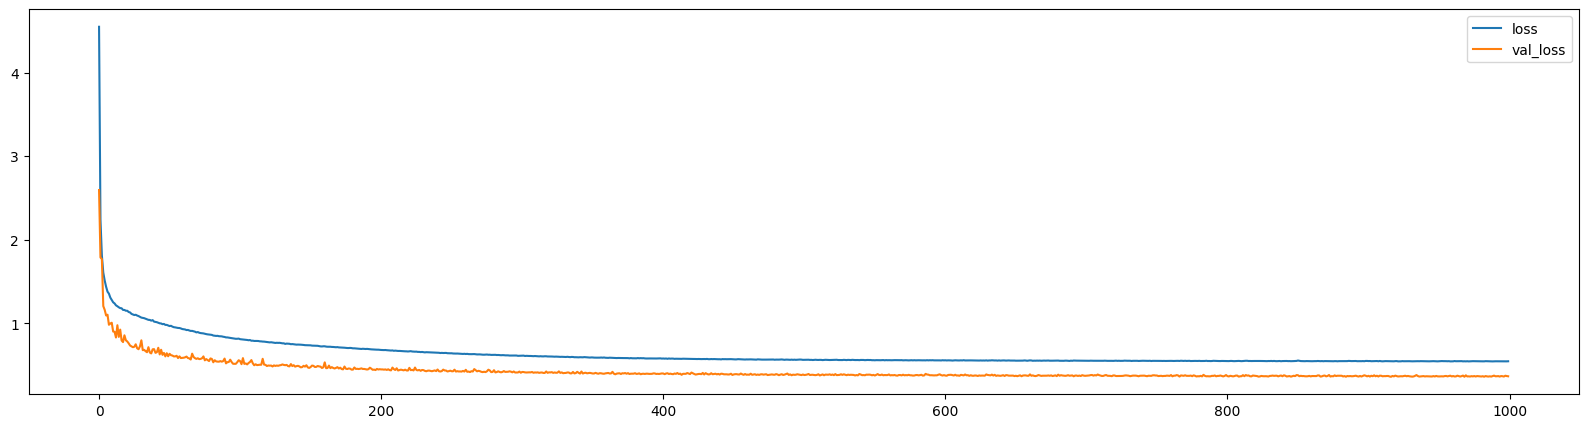

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 5))
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()

In [ ]:
model.evaluate(features, target)

2358/2358 [==============================] - 23s 6ms/step - loss: 0.3236


0.3235606849193573

In [ ]:
data_test = np.array(data_test)
data_test.shape


(4024000, 7)

In [ ]:
data_test = data_test.reshape(int(data_test.shape[0]/80), 80, data_test.shape[1])
data_test.shape

(50300, 80, 7)

In [ ]:
# if we want predict labels of test_data we will do all feature engineering, make it as array, reshape it but our limited resoursed can't do all that together
y_pred = model.predict(features, batch_size = 512)

148/148 [==============================] - 4s 15ms/step


In [ ]:
target[0]

array([ 5.83749171,  5.90779385,  7.87625392, 11.74287192, 12.23498694,
       12.86770625, 14.69556203, 15.8906985 , 15.53918778, 15.75009421,
       17.29674141, 17.22643927, 16.17190709, 17.36704356, 18.07006501,
       17.15613712, 18.28097145, 18.77308647, 17.85915858, 19.1245972 ,
       19.33550363, 18.49187789, 18.56218003, 18.63248218, 18.84338861,
       19.05429505, 19.26520149, 19.33550363, 19.33550363, 19.47610792,
       19.54641007, 17.01553283,  9.56350541,  7.87625392,  8.64957752,
        7.59504534,  7.66534749,  8.2980668 ,  7.24353461,  7.94655607,
        7.59504534,  7.45444105,  8.1574625 ,  6.82172174,  7.17323247,
        7.5247432 ,  6.96232603,  7.45444105,  7.59504534,  7.17323247,
        7.73564963,  7.24353461,  7.59504534,  7.3841389 ,  7.24353461,
        7.73564963,  7.5247432 ,  6.96232603,  7.10293032,  7.31383676,
        6.11870029,  7.03262818,  6.82172174,  6.54051316,  6.96232603,
        6.82172174,  6.54051316,  6.82172174,  6.82172174,  6.39

In [ ]:
y_pred[0]

array([ 6.0491877,  6.0154796,  8.239289 , 11.448405 , 12.478136 ,
       12.995686 , 14.568054 , 15.492248 , 15.483273 , 15.993488 ,
       16.995075 , 16.810316 , 16.480204 , 17.221474 , 17.74196  ,
       17.553684 , 18.120567 , 18.479477 , 18.381657 , 18.732073 ,
       18.981293 , 18.724648 , 18.928179 , 19.124437 , 18.996471 ,
       19.231768 , 19.571913 , 19.540007 , 19.601973 , 19.716711 ,
       19.377703 , 16.551672 ,  9.61145  ,  8.222067 ,  8.066602 ,
        7.786674 ,  7.714145 ,  7.6916866,  7.61552  ,  7.541168 ,
        7.517363 ,  7.409317 ,  7.334438 ,  7.279202 ,  7.1998725,
        7.1862106,  7.195297 ,  7.1363497,  7.2735333,  7.2628207,
        7.421663 ,  7.3976774,  7.284539 ,  7.2346063,  7.1182895,
        7.262122 ,  7.150434 ,  7.0044427,  7.2058277,  7.0453057,
        6.851919 ,  6.851894 ,  6.858375 ,  6.746594 ,  6.7122602,
        6.790281 ,  6.684245 ,  6.6457925,  6.64205  ,  6.5614977,
        6.552406 ,  6.5581822,  6.50822  ,  6.505008 ,  6.4930

In [ ]:
def draw_result(start, end, target, y_pred):
  plt.figure(figsize = (20, 7))
  plt.plot(np.reshape(target[start:end], -1), linewidth=5, label = "actual Pressure values")
  plt.plot(np.reshape(y_pred[start:end], -1), linewidth=2, label = "predict Pressure values")
  plt.legend()

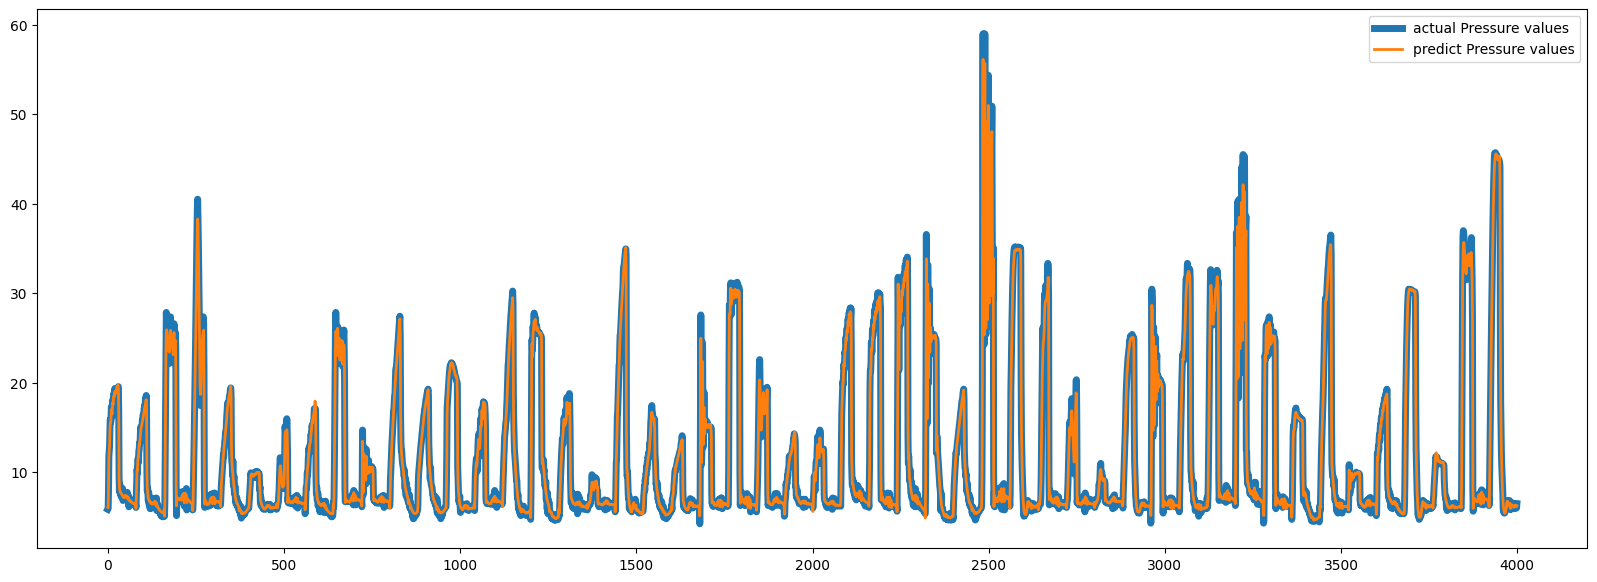

In [ ]:
draw_result(0, 50, target, y_pred)